# Image processing for centroid estimation with openCV

**Problem:** we need to find the centroid of the country highlighted by the game.

**Sources used:**
- Centroid estimation and understanding image moments : 
    - https://learnopencv.com/find-center-of-blob-centroid-using-opencv-cpp-python/
    - https://stackoverflow.com/questions/22470902/understanding-moments-function-in-opencv
    
- Sorting contours
    - https://stackoverflow.com/questions/64076884/python-opencv-return-lowest-bottom-rectangle
    - https://stackoverflow.com/questions/39403183/python-opencv-sorting-contours/39445901

## Step 1: Load the Dependencies
> This section loads some required libraries used in this notebook: **cv2**, **matplotlib**, **numpy**

*   [CV2](https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_gui/py_image_display/py_image_display.html) is a library for computer vision tasks.
*   [Matplotlib](https://matplotlib.org/) is a library which generates figures and provides graphical user interface toolkit.
*   [Numpy](https://www.numpy.org/) is an array manipulation library, mainly used for linear algebra, Fourier transform, and random number capabilities.

In [133]:
import cv2
from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams['figure.dpi'] = 120

## Step 2: Read Image from screenshots

> In this step we read images from the two screenshots, and display them using Matplotlib using pseudocolors.

* First screenshot (background) is the map background.
* Second screenshot (after) is the same map with the country we want to find being highlighted.

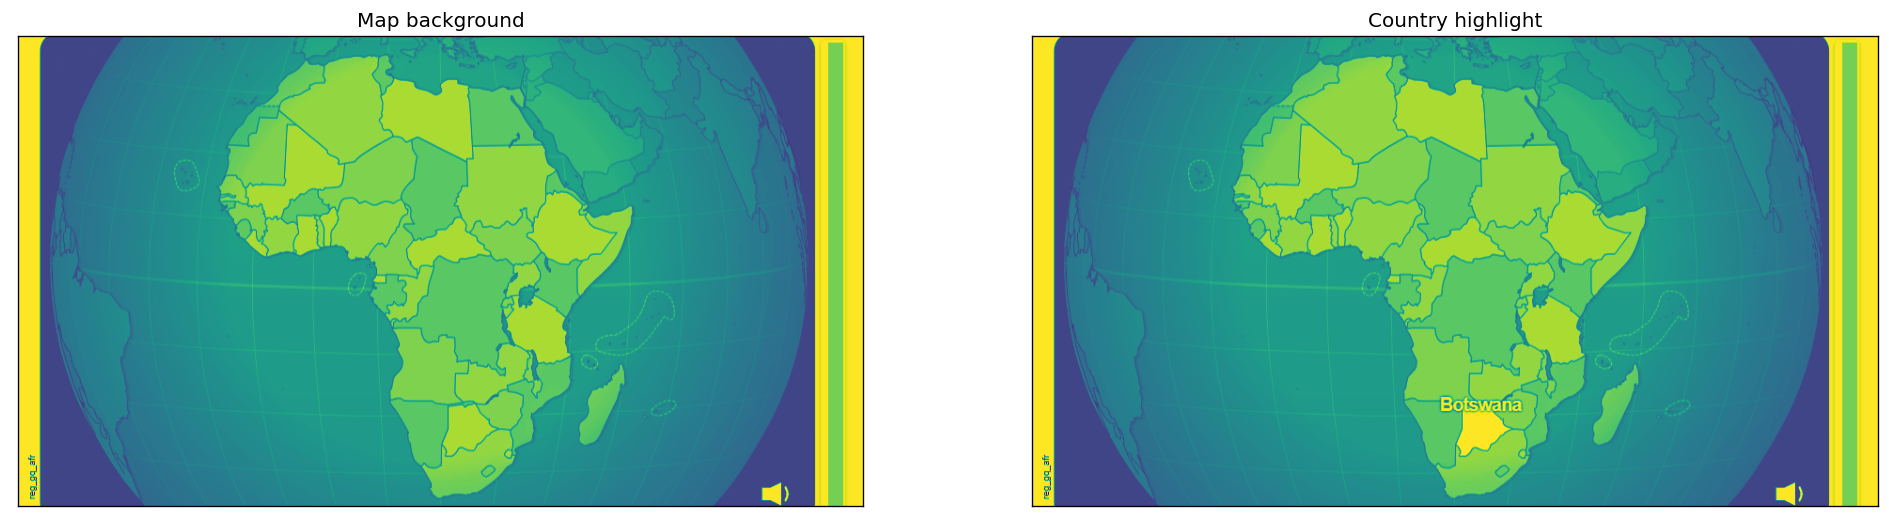

In [209]:
w_canva = 900
h_canva = 500

x_crop = 0
w_crop = w_canva
h_crop = h_canva

background = cv2.imread('bg_africa.PNG',0)[y_crop:y_crop+h_crop, x_crop:x_crop+w_crop]
after = cv2.imread('screenshot.PNG',0)[y_crop:y_crop+h_crop, x_crop:x_crop+w_crop]

# PLOT
# fig = plt.figure()
# ax = fig.add_subplot(1, 2, 1);imgplot = plt.imshow(background);ax.set_title('Background');
# plt.axis('off');
# ax = fig.add_subplot(1, 2, 2);imgplot = plt.imshow(after);ax.set_title('Country shown');
# plt.axis('off');

plt.figure(figsize=([20, 20]))
plt.subplot(121),plt.imshow(background)
plt.title('Map background'), plt.xticks([]), plt.yticks([]);
plt.subplot(122),plt.imshow(after)
plt.title('Country highlight'), plt.xticks([]), plt.yticks([]);


## Step 3: Use filters to isolate the country

> In this step we use `cv2.absdiff` to compute the difference between the two images, apply a threshold `cv2.threshold` on the resulting image. Finally isolate the country blob of pixels by using `cv2.erode`.

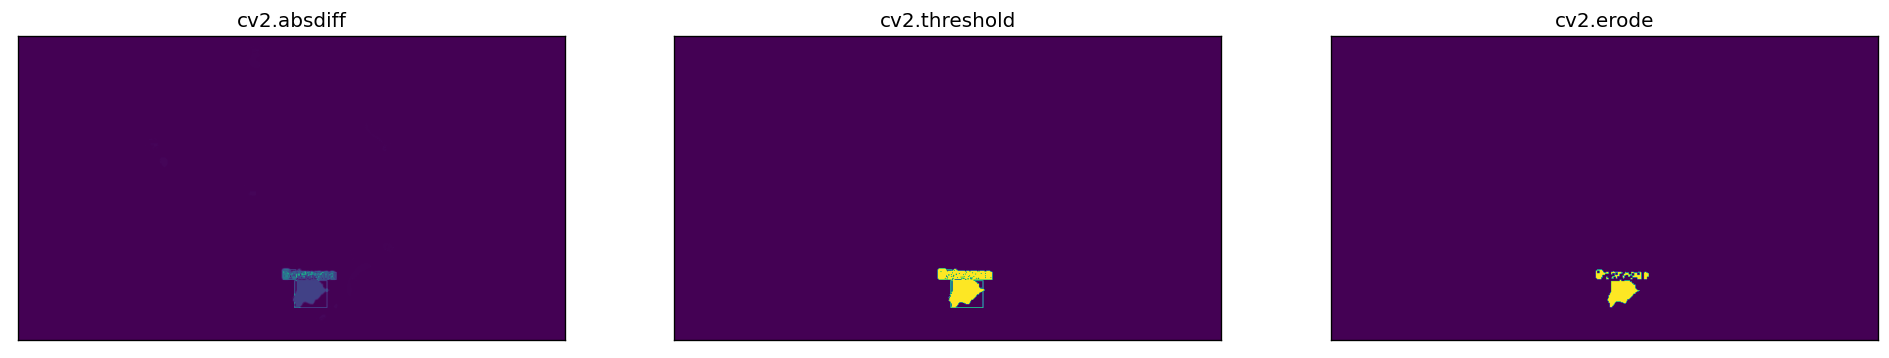

In [225]:
diff = cv2.absdiff(background, after)
ret,thresh = cv2.threshold(diff,10,255,cv2.THRESH_BINARY)
import numpy as np
kernel = np.ones((4,4), np.uint8) # Creating kernel
eroded = cv2.erode(thresh, kernel)

plt.figure(figsize=([20, 20]))
plt.subplot(131),plt.imshow(diff)
plt.title('cv2.absdiff'), plt.xticks([]), plt.yticks([])
plt.subplot(132),plt.imshow(thresh)
plt.title('cv2.threshold'), plt.xticks([]), plt.yticks([])
plt.subplot(133),plt.imshow(eroded)
plt.title('cv2.erode'), plt.xticks([]), plt.yticks([])
plt.show()

## Step 4: Contours detection and sorting

> In this step we use `cv2.findContours` to compute all the contours present on the image. Then sort `contours` list bottom to top and left to right using `sort_contours` so the lowest contour is first in the list.

In [226]:
def sort_contours(contours, x_axis_sort='LEFT_TO_RIGHT', y_axis_sort='TOP_TO_BOTTOM'):
    # initialize the reverse flag
    x_reverse = False
    y_reverse = False
    if x_axis_sort == 'RIGHT_TO_LEFT':
        x_reverse = True
    if y_axis_sort == 'BOTTOM_TO_TOP':
        y_reverse = True
    
    boundingBoxes = [cv2.boundingRect(c) for c in contours]
    
    # sorting on x-axis 
    sortedByX = zip(*sorted(zip(contours, boundingBoxes),
    key=lambda b:b[1][0], reverse=x_reverse))
    
    # sorting on y-axis 
    (contours, boundingBoxes) = zip(*sorted(zip(*sortedByX),
    key=lambda b:b[1][1], reverse=y_reverse))
    # return the list of sorted contours and bounding boxes
    return (contours, boundingBoxes)

In [227]:
contours, hierarchy = cv2.findContours(eroded, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
if len(list(contours)) > 0 :
    contours, boundingBoxes = sort_contours(contours, x_axis_sort='LEFT_TO_RIGHT', y_axis_sort='BOTTOM_TO_TOP')
else :
    pass # no contours found

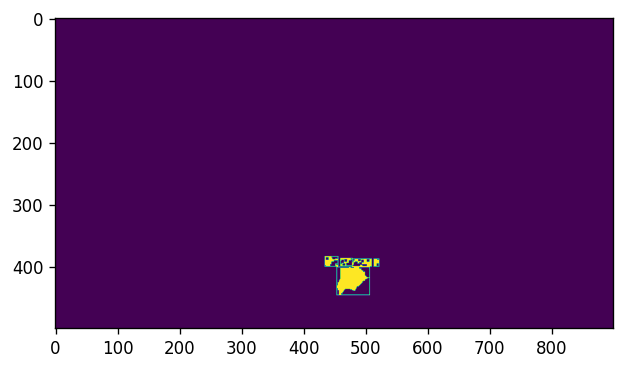

In [228]:
# Draw polygonal contour + bonding rects + circles
for i in range(len(contours)):
    cv2.rectangle(eroded, (boundingBoxes[i][0], boundingBoxes[i][1]), \
      ((boundingBoxes[i][0]+boundingBoxes[i][2]), (boundingBoxes[i][1]+boundingBoxes[i][3])), (255,255,255), 1)
    
plt.imshow(eroded);

## Final step: Centroid estimation 

> Once our `contours` list has been sorted, we calculate the moments of the first contour of the list (corresponding to the lowest contour in the image). Then use these moments to compute centroid of the country.

Centroid found at :
476 420


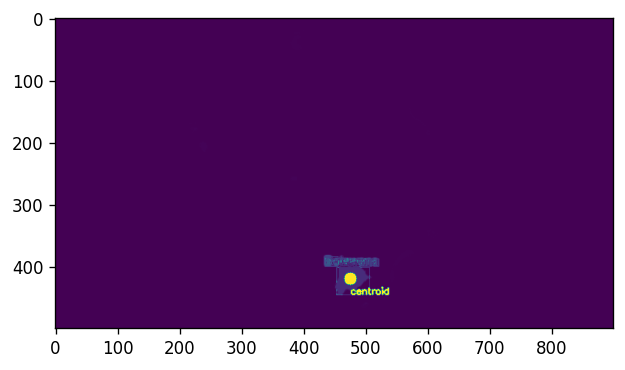

In [229]:
cXlist=[]
cYlist=[]

for c in contours:
    # calculate moments for each contour
    M = cv2.moments(c)
    if M["m00"] != 0:
        cX = int(M["m10"] / M["m00"])
        cY = int(M["m01"] / M["m00"])
        cXlist.append(cX)
        cYlist.append(cY)
    else:
        pass # do nothing, centroid value is not usable

if len(cXlist) > 0:
    cv2.circle(diff, (cXlist[0], cYlist[0]), 10, (255, 0, 0), -1)
    cv2.putText(diff, "centroid", (cXlist[0], cYlist[0] + 25),cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)
    plt.imshow(diff)
    print("Centroid found at :")
    print(cXlist[0],cYlist[0])
else:
    print("no centroid found in list") # 

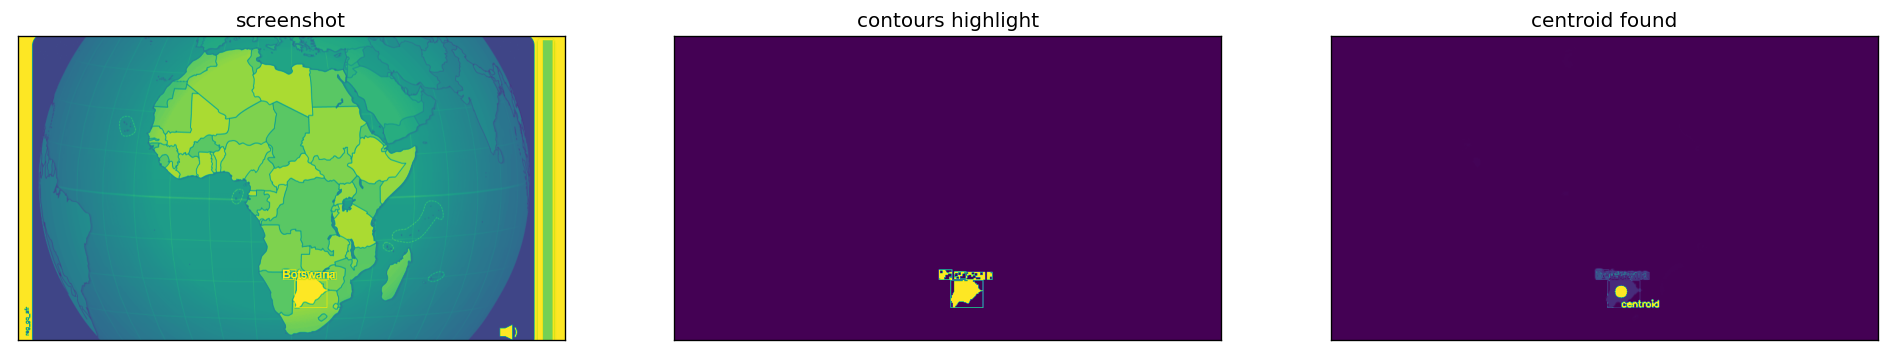

In [231]:
plt.figure(figsize=([20, 20]))
plt.subplot(131),plt.imshow(after)
plt.title('screenshot'), plt.xticks([]), plt.yticks([])
plt.subplot(132),plt.imshow(eroded)
plt.title('contours highlight'), plt.xticks([]), plt.yticks([])
plt.subplot(133),plt.imshow(diff)
plt.title('centroid found'), plt.xticks([]), plt.yticks([])
plt.show()